**IN3060/INM460 Computer Vision Coursework(PG)_Yumi Heo(230003122)**

**Face Covering Detection**

# Google Drive Setup

In [1]:
# Mount the Google Drive
# This code derives from the lab tutorial 2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Call the path to the dataset in the Google Drive
# This code derives from the lab tutorial 2
import os

drive_path = '/content/drive/MyDrive/CW_Folder_PG/CW_Dataset'
dataset_path = os.path.join('drive', 'My Drive', drive_path)

# Check any file through the path
print(os.listdir(dataset_path))

['CV2024_CW_Dataset.zip']


In [3]:
# Check the python version in colab
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [4]:
# Check the runtime
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


# Data preprocessing

In [5]:
# Import packages for data preprocessing
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.io import imread
import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import time
import copy

# Check the version of OpenCV
cv2.__version__

'4.8.0'

## Load the dataset

In [6]:
# Unzip the dataset
# This code derives from lab tutorial 6

# Identify path to zipped dataset
zip_path = os.path.join(dataset_path, 'CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

## Set the training set

In [7]:
# Define the function to load images and labels
def load_images_labels(image_dir, label_dir):
    images = []
    labels = []

    # Get the image files in order
    image_files = sorted(os.listdir(image_dir))

    # Iterate over each image file
    for image_file in image_files:
        # Check the '.jpeg' extension of the image file
        if image_file.endswith('.jpeg'):
            # Load the image
            image_path = os.path.join(image_dir, image_file)
            image = io.imread(image_path)
            images.append(image)

            # Find the corresponding the name of label file to that of the image file in text files
            label_file = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
            if os.path.exists(label_file):
                # Read the inside of the label file and load the label
                with open(label_file, 'r') as f:
                    label = f.read().strip()
                    labels.append(label)

    return images, labels

In [8]:
# Directory to training images and labels
image_dir = '/content/train/images'
label_dir = '/content/train/labels'

# Load images and labels
images, labels = load_images_labels(image_dir, label_dir)

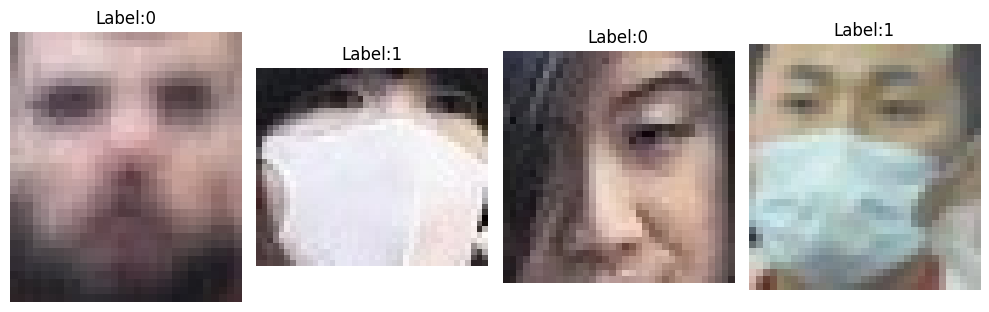

In [9]:
# Check whether the image and label have been loaded in order correctly
fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

# Set a list of the label for the plot
plot_labels = []

for i in range(4):
    # Change labels to strings and append them to a new list
    plot_labels.append(str(labels[i]))
    # Concatenate strings for each title
    ax[i].set_title('Label:' + plot_labels[i])
    ax[i].imshow(images[i])
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

In [10]:
# Change the names of variables for training set
X_train = images
y_train = labels

## Set the test set

In [11]:
# Directory to test images and labels
image_dir = '/content/test/images'
label_dir = '/content/test/labels'

# Load images and labels
images, labels = load_images_labels(image_dir, label_dir)

In [12]:
# Change the names of variables for test set
X_test = images
y_test = labels

## Check the data type of the training and test sets

In [13]:
# Check each number of images in the training set and the test set
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2394
2394
458
458


In [14]:
# Check the data type of elements in y_train and y_test
print(y_train[0:3])
print(y_test[0:3])

['0', '1', '0']
['1', '1', '1']


In [15]:
# Convert strings to float in y_train and y_test
y_train = [float(item) for item in y_train]
y_test = [float(item) for item in y_test]

In [16]:
# Double check the data type of elements in y_train and y_test
print(y_train[0:3])
print(y_test[0:3])

[0.0, 1.0, 0.0]
[1.0, 1.0, 1.0]


## Check the first index in the training set and the test set

In [17]:
# Check the first index of images and labels in the training set and test set
print("The first index in X_train:\n", (X_train[0]))
print("The first index in y_train:\n", (y_train[0]))
print("The first index in X_test:\n", (X_test[0]))
print("The first index in y_test:\n", (y_test[0]))

The first index in X_train:
 [[[128 114 114]
  [170 154 155]
  [196 176 178]
  ...
  [187 159 148]
  [170 143 134]
  [157 132 125]]

 [[130 116 116]
  [173 157 158]
  [198 178 180]
  ...
  [191 163 152]
  [170 143 134]
  [161 136 129]]

 [[128 112 113]
  [173 154 156]
  [199 179 181]
  ...
  [190 162 151]
  [172 145 136]
  [160 135 128]]

 ...

 [[ 44  35  38]
  [ 43  34  37]
  [ 47  38  43]
  ...
  [ 50  38  40]
  [ 60  41  45]
  [ 64  43  48]]

 [[ 40  28  32]
  [ 40  29  33]
  [ 45  34  40]
  ...
  [ 62  47  50]
  [ 68  47  52]
  [ 68  43  49]]

 [[ 46  31  36]
  [ 47  32  37]
  [ 51  36  41]
  ...
  [ 72  53  57]
  [ 76  51  55]
  [ 75  46  51]]]
The first index in y_train:
 0.0
The first index in X_test:
 [[[28 25 20]
  [38 33 27]
  [49 42 36]
  ...
  [18 22 23]
  [21 29 31]
  [15 25 26]]

 [[52 47 41]
  [55 48 40]
  [68 59 50]
  ...
  [25 29 28]
  [14 22 24]
  [21 26 29]]

 [[88 81 71]
  [87 79 68]
  [91 77 66]
  ...
  [25 27 24]
  [26 30 31]
  [24 25 29]]

 ...

 [[90 92 91]
  [

## Check the balance between the classes in the target

In [ ]:
# Check the total number of unique values in the label
nunique_labels = len(set(y_test))
nunique_labels

3

In [ ]:
# Check the histogram of the number of unique values in the training and test label
# Find the unique value in the training label
train_values = list(set(y_train))
# Count the values in the training label
train_values_counts = [y_train.count(value) for value in train_values]

# Find the unique value in the test label
test_values = list(set(y_test))
# Count the values in the test label
test_values_counts = [y_test.count(value) for value in test_values]

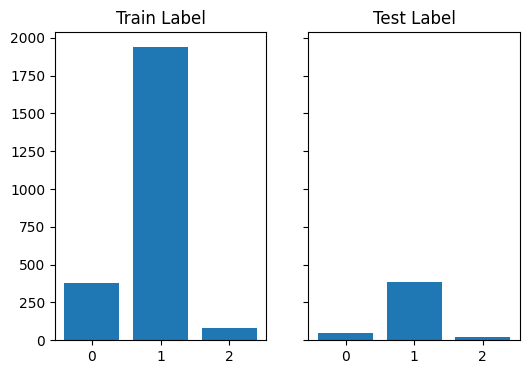

In [ ]:
# Plot histograms of the counts of unique values in both labels
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

ax[0].bar(train_values, train_values_counts)
ax[1].bar(test_values, test_values_counts)
ax[0].set_title('Train Label')
ax[1].set_title('Test Label')
plt.show()

## Image resizing

In [ ]:
# Find the smallest size of the image in the training set

# Initialise with a positive infinity value
train_smallest_height = float('inf')
train_smallest_width = float('inf')
train_smallest_channel = float('inf')

# Iterate over all images in the training set
for image in X_train:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Update the smallest width and height
    if height < train_smallest_height:
      train_smallest_height = height
    if width < train_smallest_width:
      train_smallest_width = width
    if channels < train_smallest_channel:
      train_smallest_channel = channels

print("The smallest height in the training set:", train_smallest_height)
print("The smallest width in the training set:", train_smallest_width)
print("The smallest channel in the training set:", train_smallest_channel)

The smallest height in the training set: 11
The smallest width in the training set: 16
The smallest channel in the training set: 3


In [ ]:
# Find the smallest size of the image in the test set

# Initialise with a positive infinity value
test_smallest_height = float('inf')
test_smallest_width = float('inf')
test_smallest_channel = float('inf')

# Iterate over all images in the training set
for image in X_test:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Update the smallest width and height
    if height < test_smallest_height:
      test_smallest_height = height
    if width < test_smallest_width:
      test_smallest_width = width
    if channels < test_smallest_channel:
      test_smallest_channel = channels

print("The smallest height in the test set:", test_smallest_height)
print("The smallest width in the test set:", test_smallest_width)
print("The smallest channel in the test set:", test_smallest_channel)

The smallest height in the test set: 13
The smallest width in the test set: 16
The smallest channel in the test set: 3


In [ ]:
# Find the largest size of the image in the training set

# Initialise with a positive infinity value
train_largest_height = float('-inf')
train_largest_width = float('-inf')
train_largest_channel = float('-inf')

# Iterate over all images in the training set
for image in X_train:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Update the largest width and height
    if height > train_largest_height:
      train_largest_height = height
    if width > train_largest_width:
      train_largest_width = width
    if channels > train_largest_channel:
      train_largest_channel = channels

print("The largest height in the training set:", train_largest_height)
print("The largest width in the training set:", train_largest_width)
print("The largest channel in the training set:", train_largest_channel)

The largest height in the training set: 340
The largest width in the training set: 317
The largest channel in the training set: 3


In [ ]:
# Find the largest size of the image in the test set

# Initialise with a positive infinity value
test_largest_height = float('-inf')
test_largest_width = float('-inf')
test_largest_channel = float('-inf')

# Iterate over all images in the training set
for image in X_test:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Update the largest width and height
    if height > test_largest_height:
      test_largest_height = height
    if width > test_largest_width:
      test_largest_width = width
    if channels > test_largest_channel:
      test_largest_channel = channels

print("The largest height in the test set:", test_largest_height)
print("The largest width in the test set:", test_largest_width)
print("The largest channel in the test set:", test_largest_channel)

The largest height in the test set: 282
The largest width in the test set: 241
The largest channel in the test set: 3


In [ ]:
# Find the average size of the image in the training set

# Initialize variables to accumulate total height and width
total_height = 0
total_width = 0

# Iterate over all images in the training set
for image in X_train:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Accumulate total height and width
    total_height += height
    total_width += width

# Calculate the average height and width
mean_height = total_height / len(X_test)
mean_width = total_width / len(X_test)

print("The average height in the training set:", mean_height)
print("The average width in the training set:", mean_width)

The average height in the training set: 232.8013100436681
The average width in the training set: 208.5131004366812


In [ ]:
# Find the mode size of the image in the training set

# Import statistics to get the mode
import statistics

# Initialize lists to store heights and widths
heights = []
widths = []

# Iterate over all images in the test set
for image in X_train:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Append height and width to each respective list
    heights.append(height)
    widths.append(width)

# Find the mode of heights and widths
mode_height = statistics.mode(heights)
mode_width = statistics.mode(widths)

print("The mode height in the training set:", mode_height)
print("The mode width in the training set:", mode_width)

The mode height in the training set: 23
The mode width in the training set: 18


In [ ]:
# Find the average size of the image in the test set

# Initialize variables to accumulate total height and width
total_height = 0
total_width = 0

# Iterate over all images in the test set
for image in X_test:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Accumulate total height and width
    total_height += height
    total_width += width

# Calculate the mean height and width
mean_height = total_height / len(X_test)
mean_width = total_width / len(X_test)

print("The mean height in the test set:", mean_height)
print("The mean width in the test set:", mean_width)

The mean height in the test set: 44.30786026200873
The mean width in the test set: 39.7532751091703


In [ ]:
# Find the mode size of the image in the test set

# Initialize lists to store heights and widths
heights = []
widths = []

# Iterate over all images in the test set
for image in X_test:
    # Get the dimensions of the current image
    height, width, channels = image.shape

    # Append height and width to each respective list
    heights.append(height)
    widths.append(width)

# Find the mode of heights and widths
mode_height = statistics.mode(heights)
mode_width = statistics.mode(widths)

print("The mode height in the test set:", mode_height)
print("The mode width in the test set:", mode_width)

The mode height in the test set: 20
The mode width in the test set: 22


### Resize with interpolation: INTER_LINEAR

In [ ]:
# Resize the training image to 256x256 to use both SVM and CNN models
# The resized training images will be compared according to each interpolation method

# Initialize a list to store resized training images with INTER_LINEAR
resized_X_train_linear = []

# Resize each image in X_train to 256x256
resize_height = 256
resize_width = 256
resize_points = (resize_width, resize_height)

for image in X_train:
    # As for interpolation: INTER_LINEAR / INTER_CUBIC / INTER_NEAREST / INTER_AREA
    resized_image = cv2.resize(image, resize_points, interpolation=cv2.INTER_LINEAR)
    resized_X_train_linear.append(resized_image)

# Convert the list of resized images to a NumPy array
#resized_X_train_linear_array = np.array(resized_X_train_linear)

### Resize with interpolation: INTER_CUBIC

In [ ]:
# Initialize a list to store resized training images with INTER_CUBIC
resized_X_train_cubic = []

# Resize each image in X_train to 256x256
resize_height = 256
resize_width = 256
resize_points = (resize_width, resize_height)

for image in X_train:
    resized_image = cv2.resize(image, resize_points, interpolation=cv2.INTER_CUBIC)
    resized_X_train_cubic.append(resized_image)

# Convert the list of resized images to a NumPy array
#resized_X_train = np.array(resized_X_train_cubic)

### Resize with interpolation: INTER_NEAREST

In [ ]:
# Initialize a list to store resized training images with INTER_NEAREST
resized_X_train_nearest = []

# Resize each image in X_train to 256x256
resize_height = 256
resize_width = 256
resize_points = (resize_width, resize_height)

for image in X_train:
    resized_image = cv2.resize(image, resize_points, interpolation=cv2.INTER_NEAREST)
    resized_X_train_nearest.append(resized_image)

# Convert the list of resized images to a NumPy array
#resized_X_train = np.array(resized_X_train_nearest)

### Resize with interpolation: INTER_AREA

In [18]:
# Initialize a list to store resized training images with INTER_AREA
resized_X_train_area = []

# Resize each image in X_train to 256x256
resize_height = 256
resize_width = 256
resize_points = (resize_width, resize_height)

for image in X_train:
    resized_image = cv2.resize(image, resize_points, interpolation=cv2.INTER_AREA)
    resized_X_train_area.append(resized_image)

# Convert the list of resized images to a NumPy array
resized_X_train_array = np.array(resized_X_train_area)

### Resized training image with the label

NameError: name 'resized_X_train_linear' is not defined

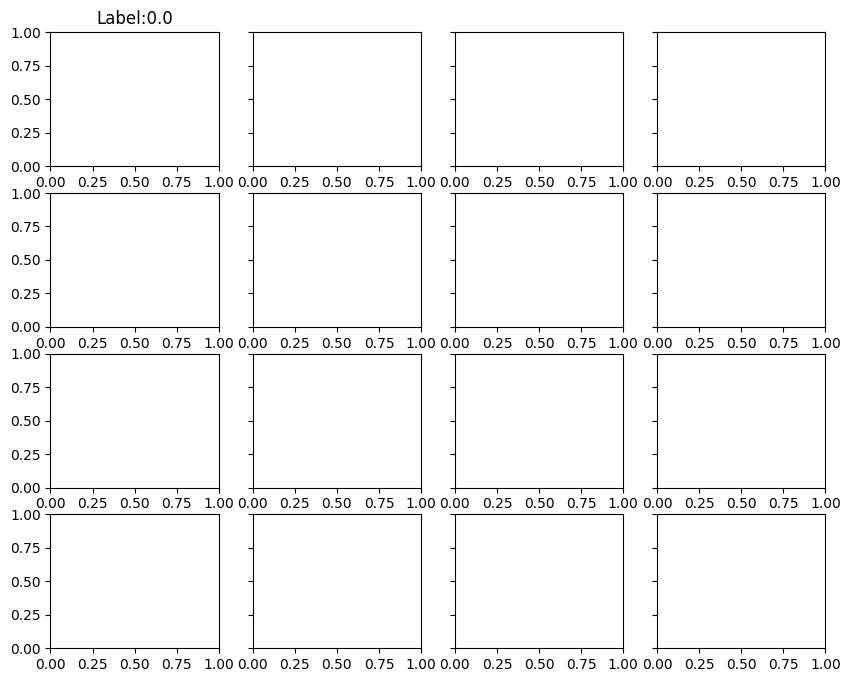

In [ ]:
# Check the resized training image with the label
fig, ax = plt.subplots(4, 4, figsize=(10, 8), sharey=True)

# Set a list of the label for the resized training image to plot
resized_plot_labels = []

for i in range(4):
    # Change labels to strings and append them to a new list
    resized_plot_labels.append(str(y_train[i]))
    # Concatenate strings for each title
    ax[0, i].set_title('Label:' + resized_plot_labels[i])
    ax[0, i].imshow(resized_X_train_linear[i])
    ax[0, i].set_ylabel('INTER_LINEAR')

    ax[1, i].set_title('Label:' + resized_plot_labels[i])
    ax[1, i].imshow(resized_X_train_cubic[i])
    ax[1, i].set_ylabel('INTER_CUBIC')

    ax[2, i].set_title('Label:' + resized_plot_labels[i])
    ax[2, i].imshow(resized_X_train_nearest[i])
    ax[2, i].set_ylabel('INTER_NEAREST')

    ax[3, i].set_title('Label:' + resized_plot_labels[i])
    ax[3, i].imshow(resized_X_train_area[i])
    ax[3, i].set_ylabel('INTER_AREA')

fig.tight_layout()
plt.show()

Resized images with inter-area interpolation will be used as training samples.

## Training and Validation sets for SVM

In [ ]:
# Print the shape and dtype of the training samples
print("Shape of the training images :", resized_X_train_array[0].shape)
print("Dtype of the training images :", resized_X_train_array[0].dtype)
print("Samples in the training images:", len(resized_X_train_array))
print("Dtype of the training labels :", type(y_train[0]))
print("Samples in the training labels:", len(y_train))

Shape of the training images : (256, 256, 3)
Dtype of the training images : uint8
Samples in the training images: 2394
Dtype of the training labels : <class 'float'>
Samples in the training labels: 2394


In [ ]:
# Divide the training set to 80% for training and 20% for validation sets for the SVM model
from sklearn.model_selection import train_test_split

X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(resized_X_train_array, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

In [ ]:
# Print the shape and dtype of the test samples
print("Shape of the training images :", X_val_svm[0].shape)
print("Dtype of the training images :", X_val_svm[0].dtype)
print("Samples in the training images:", len(X_val_svm))
print("Dtype of the training labels :", type(y_val_svm[0]))
print("Samples in the training labels:", len(y_val_svm))

Shape of the training images : (256, 256, 3)
Dtype of the training images : uint8
Samples in the training images: 479
Dtype of the training labels : <class 'float'>
Samples in the training labels: 479


In [ ]:
# Print the shape and dtype of the test samples
print("Shape of the training images :", X_test[0].shape)
print("Dtype of the training images :", X_test[0].dtype)
print("Samples in the training images:", len(X_test))
print("Dtype of the training labels :", type(y_test[0]))
print("Samples in the training labels:", len(y_test))

Shape of the training images : (45, 43, 3)
Dtype of the training images : uint8
Samples in the training images: 458
Dtype of the training labels : <class 'float'>
Samples in the training labels: 458


# Model with SIFT using K-Means & SVM

## Define the SIFT

In [ ]:
# Set the SIFT detector
sift = cv2.SIFT_create()

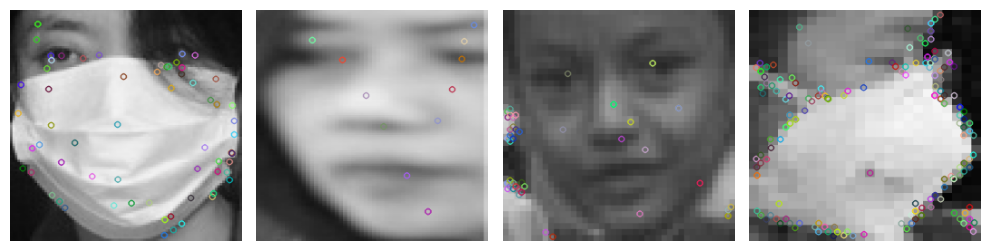

In [ ]:
# This SIFT code is from lab 6
# Import the relevant libraries
from skimage import color, img_as_ubyte

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train_svm)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train_svm[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train_svm[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

## Apply K-means **clustering**

In [ ]:
# Perform k-means clustering on the SIFT features
from sklearn.cluster import KMeans
from sklearn import svm, metrics

In [ ]:
# This code is from lab 6
# Set the number of centroids/codewords
k = len(np.unique(y_train_svm)) * 10

# Define k-means
kmeans = KMeans(n_clusters=k, n_init='auto').fit(des_array)

In [ ]:
# This code is from lab 6
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

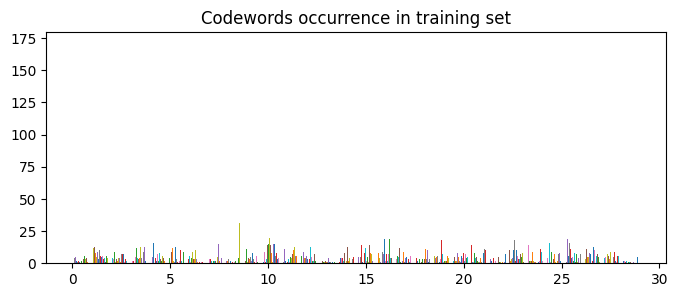

In [ ]:
# This SIFT code is from lab 6
# Plot the histogram for the codewords
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

## Build and train the SVM model

In [ ]:
# This code is from lab 6
# Create the SVM model
sift_svm_classifier = svm.SVC(kernel='rbf')

# Train the model
sift_svm_classifier.fit(hist_array, y_train_list)

SVC()

## Validation

In [ ]:
# This code is from lab 6
# Get points, extract feature descriptors and append codewords to the histograms from the validation set
hist_list = []

for i in range(len(X_val_svm)):
    img = img_as_ubyte(color.rgb2gray(X_val_svm[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_val_svm = [y_val_svm[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [ ]:
# Predict labels using the trained SVM model
y_val_pred = sift_svm_classifier.predict(hist_array).tolist()

In [ ]:
# Check the evaluation metrics
print(f"""Classification report for classifier {sift_svm_classifier}:
      {metrics.classification_report(y_val_svm, y_val_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

         0.0       1.00      0.01      0.03        75
         1.0       0.81      1.00      0.90       388
         2.0       0.00      0.00      0.00        16

    accuracy                           0.81       479
   macro avg       0.60      0.34      0.31       479
weighted avg       0.81      0.81      0.73       479




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


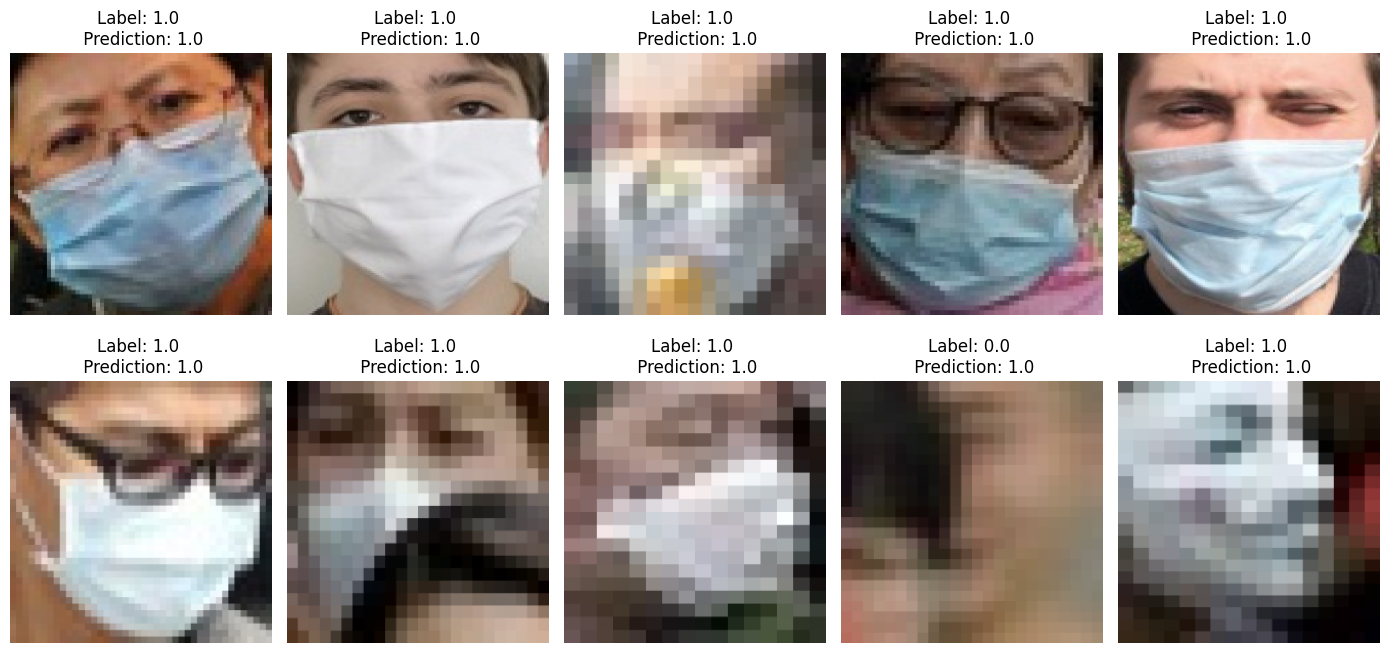

In [ ]:
# Plot the predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_val_svm[i])
    ax[i].set_title(f'Label: {y_val_svm[i]} \n Prediction: {y_val_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

## Test

In [ ]:
# Import the library to resize the train image for the SVM model with SIFT
from skimage.transform import resize

# Define the resizng size
target_size = (256, 256)

# List to store resized images
resized_X_test_siftsvm = []

# Resize images in the test set
for image in X_test:
    resized_image = resize(image, target_size, anti_aliasing=True) # To make sure antialiasing for bilinear or bicubic modes
    resized_X_test_siftsvm.append(resized_image)

# This code is from lab 6
# Get points, extract feature descriptors and append codewords to the histograms from the test set
hist_list = []

for i in range(len(resized_X_test_siftsvm)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test_not_empty = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [ ]:
# Predict labels using the trained SVM model
y_test_pred = sift_svm_classifier.predict(hist_array).tolist()

In [ ]:
# Check the evaluation metrics
print(f"""Classification report for classifier {sift_svm_classifier}:
      {metrics.classification_report(y_test_not_empty, y_test_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

         0.0       0.25      0.04      0.07        50
         1.0       0.85      0.99      0.91       384
         2.0       0.00      0.00      0.00        19

    accuracy                           0.84       453
   macro avg       0.37      0.34      0.33       453
weighted avg       0.75      0.84      0.78       453




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


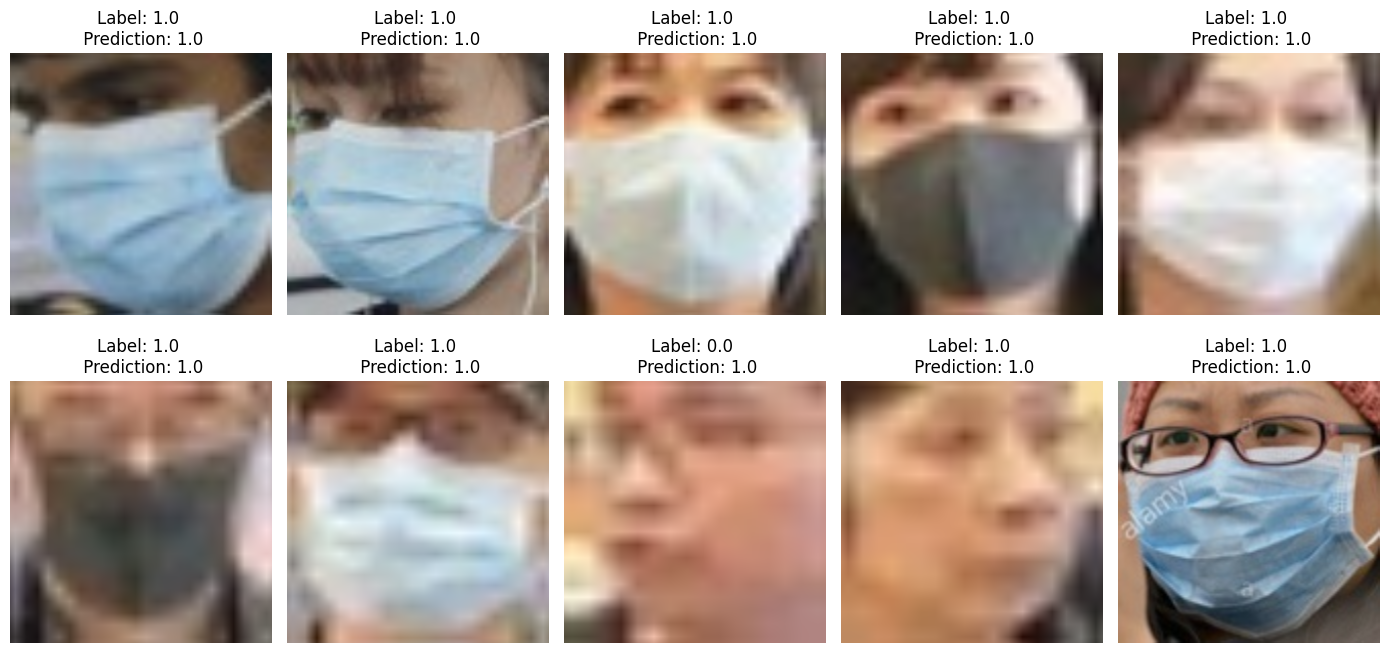

In [ ]:
# Plot the predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(resized_X_test_siftsvm[i])
    ax[i].set_title(f'Label: {y_test_not_empty[i]} \n Prediction: {y_test_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
import itertools

In [ ]:
# Define the SVM model for grid search
classifier = svm.SVC(kernel='rbf')

# Perform grid search with cross-validation to tune hyperparameters
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}

for C, gamma in itertools.product(param_grid['C'], param_grid['gamma']):
    print(f"Training model with C: {C}, gamma: {gamma}")
    grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(resized_X_train_linear_array, y_train_array)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Training model with C: 0.1, gamma: 0.01


NameError: name 'resized_X_train_linear_array' is not defined

# Model with HOG & SVM

## Extract HOGs

In [ ]:
# This code is from lab 5
# Import libraries
from skimage.feature import hog
from skimage import color

# Define HOG parameters
orientations = 8
pixels_per_cell = (16, 16)
cells_per_block = (1, 1)

# Lists to store HOG features and labels
hog_features_list = []
hog_image_list = []
y_train_list = []

for i in range(len(X_train_svm)):
    # Get HOG features for the image
    img = color.rgb2gray(X_train_svm[i])
    hog_features, hog_images = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)

    # Append HOG features and label to respective lists
    hog_features_list.append(hog_features)
    hog_image_list.append(hog_images)
    y_train_list.append(y_train_svm[i])

# Convert to array for easier handling
hog_features_array = np.vstack(hog_features_list)

In [ ]:
# This code is from lab 5
# Check the number of samples and the HOG descriptor vector
print('HOG descriptor shape =', hog_features_array.shape)

HOG descriptor shape = (1915, 2048)


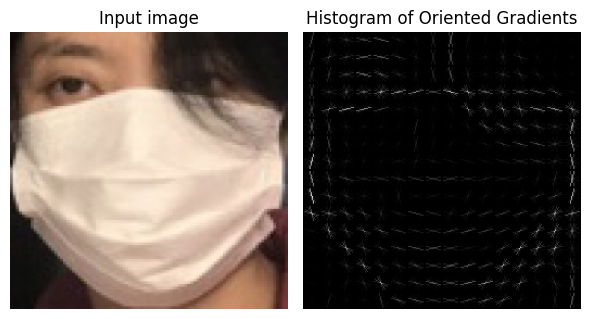

In [ ]:
# This code is from lab 5
# Import the library to visualise
from skimage import exposure

# Plot the input image and its corresponding HOG
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)

# Plot input image
ax[0].axis('off')
ax[0].imshow(X_train_svm[0])
ax[0].set_title('Input image')

# Plot HOG image
hog_image_rescaled = exposure.rescale_intensity(hog_image_list[0], in_range=(0, 10))  # Rescale HOG image for better display
ax[1].axis('off')
ax[1].imshow(hog_image_rescaled, cmap='gray')
ax[1].set_title('Histogram of Oriented Gradients')

fig.tight_layout()
plt.show()

## Build and train the SVM model

In [ ]:
# This code is from lab 6
# Create the SVM model
hog_svm_classifier = svm.SVC(kernel='rbf')

# Train the model
hog_svm_classifier.fit(hog_features_array, y_train_list)

SVC()

## Validation

In [ ]:
# Extract HOG features from the validation dataset
hog_features_val_list = []

for i in range(len(X_val_svm)):
    img = color.rgb2gray(X_val_svm[i])
    hog_features_val = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    hog_features_val_list.append(hog_features_val)

# Convert to array
hog_features_val_array = np.vstack(hog_features_val_list)

In [ ]:
# Predict labels using the trained SVM model
y_val_pred = hog_svm_classifier.predict(hog_features_val_array)

In [ ]:
# Check the evaluation metrics
print(f"""Classification report for classifier {hog_svm_classifier}:
      {metrics.classification_report(y_val_svm, y_val_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

         0.0       1.00      0.05      0.10        75
         1.0       0.82      1.00      0.90       388
         2.0       0.00      0.00      0.00        16

    accuracy                           0.82       479
   macro avg       0.61      0.35      0.33       479
weighted avg       0.82      0.82      0.74       479




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


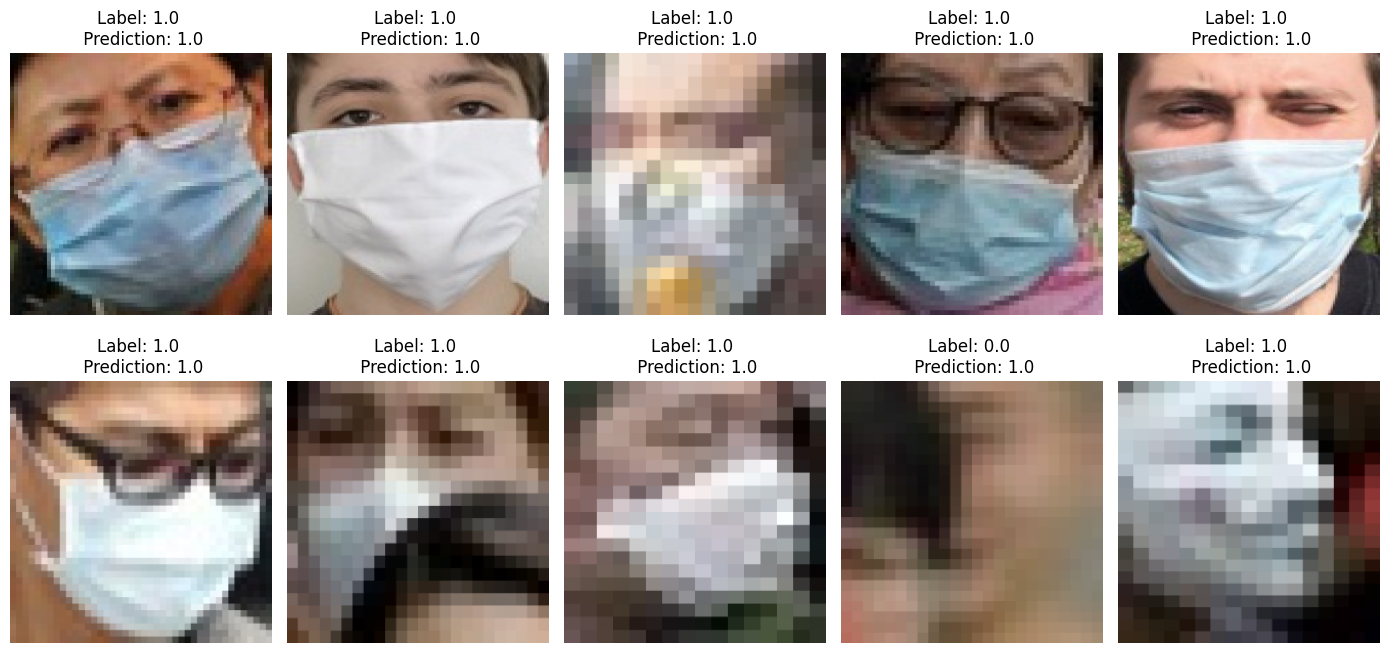

In [ ]:
# Plot the predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_val_svm[i])
    ax[i].set_title(f'Label: {y_val_svm[i]} \n Prediction: {y_val_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

## Test

In [ ]:
# Define the resizng size
target_size = (256, 256)

# List to store resized images
resized_X_test_hogsvm = []

# Resize images in the test set
for image in X_test:
    resized_image = resize(image, target_size, anti_aliasing=True) # To make sure antialiasing for bilinear or bicubic modes
    resized_X_test_hogsvm.append(resized_image)

# Extract HOG features
hog_features_test_list = []
for img in resized_X_test_hogsvm:
    img_gray = color.rgb2gray(img)
    hog_features_test = hog(img_gray, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    hog_features_test_list.append(hog_features_test)

# Convert to array
hog_features_test_array = np.vstack(hog_features_test_list)

In [ ]:
# Predict labels using the trained SVM model
y_test_pred = hog_svm_classifier.predict(hog_features_test_array)

In [ ]:
print(f"""Classification report for classifier {hog_svm_classifier}:
      {metrics.classification_report(y_test, y_test_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

         0.0       1.00      0.10      0.18        51
         1.0       0.86      1.00      0.92       388
         2.0       0.00      0.00      0.00        19

    accuracy                           0.86       458
   macro avg       0.62      0.37      0.37       458
weighted avg       0.84      0.86      0.80       458




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


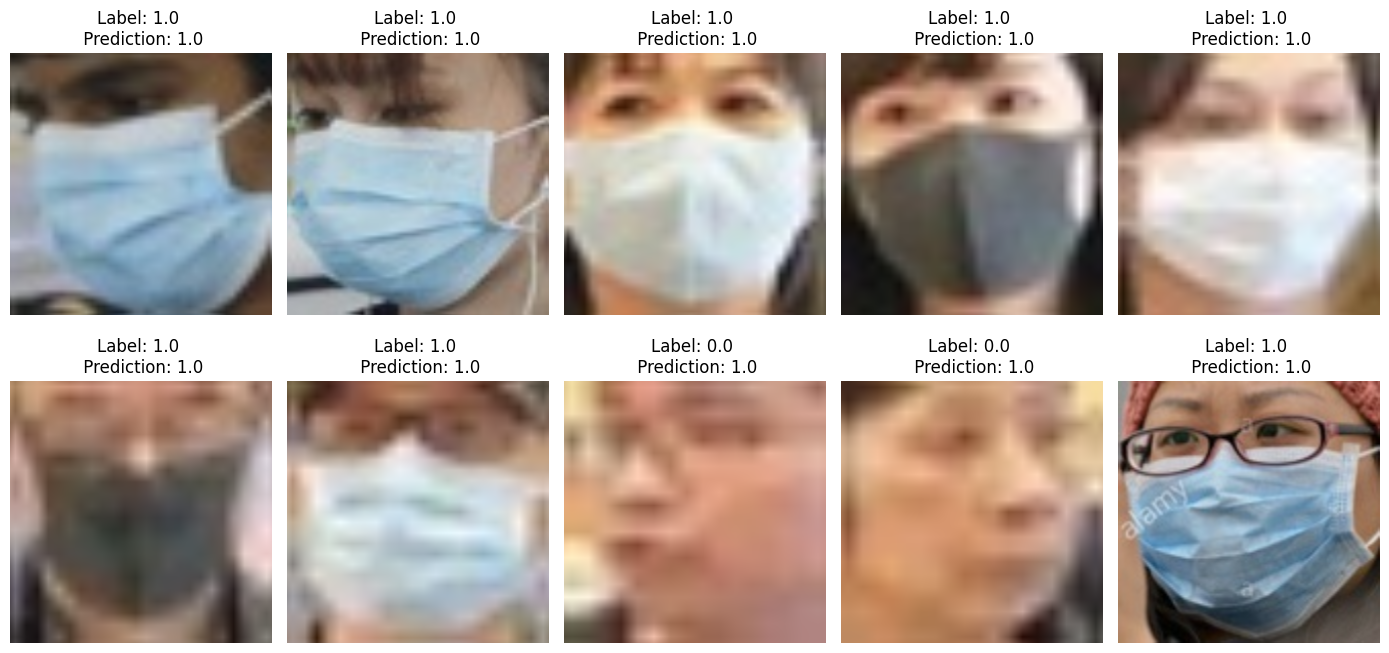

In [ ]:
# Plot the predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(resized_X_test_hogsvm[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_test_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

# CNN model

## Data augmentation

In [19]:
# Check the length of resized X train with inter area interpolation
print(len(resized_X_train_array))
print(resized_X_train_array.shape)

2394
(2394, 256, 256, 3)


In [20]:
# Change y_train(list) to numpy array
y_train_array = np.array(y_train)
# Check the length of y train array
print(len(y_train_array))

2394


In [21]:
# Check the data type of X_train and y_train
print(resized_X_train_array[0].dtype)
print(y_train_array[0].dtype)

uint8
float64


In [22]:
# Change the data type of the resized training set to float
from skimage import img_as_float

resized_X_train_float = img_as_float(resized_X_train_array)

In [23]:
# Check the data type
print(resized_X_train_float[0].dtype)

float64


In [24]:
# Check the minimum and maximum data in the resized training image for normalisation
print("Min data:", np.min(resized_X_train_float))
print("Max data:", np.max(resized_X_train_float))

Min data: 0.0
Max data: 1.0


### Check the average and standard deviation of each channel

In [25]:
# Get the mean and standard deviation for each channel
red_channel_mean = np.mean(resized_X_train_float[:,:,0])
green_channel_mean = np.mean(resized_X_train_float[:,:,1])
blue_channel_mean = np.mean(resized_X_train_float[:,:,2])

red_channel_std = np.std(resized_X_train_float[:,:,0])
green_channel_std = np.std(resized_X_train_float[:,:,1])
blue_channel_std = np.std(resized_X_train_float[:,:,2])

print("Red channel:")
print("Mean pixel intensity:", red_channel_mean)
print("Standard deviation:", red_channel_std)

print("\nGreen channel:")
print("Mean pixel intensity:", green_channel_mean)
print("Standard deviation:", green_channel_std)

print("\nBlue channel:")
print("Mean pixel intensity:", blue_channel_mean)
print("Standard deviation:", blue_channel_std)

Red channel:
Mean pixel intensity: 0.3633463744294012
Standard deviation: 0.2508556262014114

Green channel:
Mean pixel intensity: 0.36332502177284165
Standard deviation: 0.2508057273688698

Blue channel:
Mean pixel intensity: 0.3636546132829348
Standard deviation: 0.25064988944421274


In [26]:
# Store the values to lists
train_means = [red_channel_mean, green_channel_mean, blue_channel_std]
train_stds = [red_channel_std, green_channel_std, blue_channel_std]

### Define the transformation for training set and validation set

In [27]:
from torchvision import transforms

# Data augmentation and normalization for training
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_means, train_stds)
        ])

In [ ]:
# Data augmentation and normalization for validation
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(train_means, train_stds)
    ])

In [28]:
from torch.utils.data import Dataset

class CNN_trainset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

In [29]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(resized_X_train_float, y_train_array, test_size=0.2, random_state=42)

In [32]:
train_dataset = CNN_trainset(X_train_cnn, y_train_cnn, transform=train_transform)

In [55]:
train_dataset[0]

(tensor([[[ 0.8340,  0.8340,  0.8183,  ...,  0.2712,  0.2712,  0.2712],
          [ 0.8340,  0.8340,  0.8183,  ...,  0.2712,  0.2712,  0.2712],
          [ 0.8340,  0.8340,  0.8183,  ...,  0.2712,  0.2712,  0.2712],
          ...,
          [ 0.2399,  0.2399,  0.3337,  ...,  1.3498,  1.3498,  1.3498],
          [ 0.1774,  0.1774,  0.2868,  ...,  1.3655,  1.3655,  1.3655],
          [ 0.0523,  0.0523,  0.1774,  ...,  1.3967,  1.3967,  1.3967]],
 
         [[ 0.3808,  0.3808,  0.3808,  ..., -0.0883, -0.0883, -0.0883],
          [ 0.3808,  0.3808,  0.3808,  ..., -0.0883, -0.0883, -0.0883],
          [ 0.3808,  0.3808,  0.3808,  ..., -0.0883, -0.0883, -0.0883],
          ...,
          [-0.0570, -0.0570,  0.0211,  ...,  1.0844,  1.0844,  1.0844],
          [-0.1196, -0.1196, -0.0258,  ...,  1.0844,  1.0844,  1.0844],
          [-0.2447, -0.2447, -0.1196,  ...,  1.1000,  1.1000,  1.1000]],
 
         [[ 0.5489,  0.5489,  0.5176,  ...,  0.1108,  0.1108,  0.1108],
          [ 0.5489,  0.5489,

In [34]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Create custom datasets
train_dataset = CNNDataset(X_train_cnn, y_train_cnn, transform=train_transform)
val_dataset = CNNDataset(X_val_cnn, y_val_cnn, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [35]:
model = models.resnext50_32x4d(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 112MB/s]


In [36]:
num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
torch.cuda.empty_cache()

In [39]:
model = model.to(device)

In [57]:
def train_model(model, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        print('----------------')

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in train_loader:
            # move data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.long())  # Convert labels to LongTensor

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    print("Training completed")

    return model


In [58]:
model_ft = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1
----------------
Epoch 2
----------------
Epoch 3
----------------
Epoch 4
----------------
Epoch 5
----------------
Epoch 6
----------------
Epoch 7
----------------
Epoch 8
----------------
Epoch 9
----------------
Epoch 10
----------------
Training completed


In [63]:
print(type(model_ft))

<class 'torchvision.models.resnet.ResNet'>


In [64]:
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

    accuracy = running_corrects / total_samples
    print(f"Accuracy on test set: {accuracy:.4f}")

In [ ]:

# Example usage:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model_ft.eval()  # Ensure the model is in evaluation mode
test_model(model_ft, test_loader, device)

In [ ]:
# Move channels dimension to the correct position
train_images_tensor = train_images_tensor.permute(0, 3, 1, 2)

# Verify the new shape of the input images tensor
print("New shape of the training images tensor:", train_images_tensor.shape)

New shape of the training images tensor: torch.Size([2394, 3, 11, 11])


## Pre-trained CNN model

In [ ]:
# Convert the list of transformed images to a tensor
#train_image = torch.stack(X_train_augmented)

In [ ]:
# Convert y_train to a tensor
y_train_tensor = torch.tensor(y_train)

# Create a TensorDataset with train_image and y_train_tensor
combined_dataset = TensorDataset(train_image, y_train_tensor)

# Create a dataloader
batch_size = 4  # Set your desired batch size
shuffle = True   # Set to True if you want to shuffle the data
num_workers = 2  # Number of processes to use for data loading
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

### Resnet18

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.4MB/s]


In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, nunique_labels)

In [ ]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

NameError: name 'model_ft' is not defined

In [ ]:
import torch
from torch import nn, optim
import time
import copy

def train_model(model, criterion, optimizer, scheduler, dataloader, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store loss and accuracy for plotting
    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        dataset_size = len(dataloader.dataset)

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print(f"Train loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

        # Store loss and accuracy for plotting
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

        # Update learning rate with scheduler
        scheduler.step()

        # Deep copy the model if it has the best accuracy
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best train acc: {best_acc:4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, acc_history

In [ ]:
print(type(model_ft))

<class 'tuple'>


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloader,
                       num_epochs=25)

Epoch 0/24
----------------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train loss: 0.6660 acc: 0.7757

Epoch 1/24
----------------
Train loss: 0.5559 acc: 0.8045

Epoch 2/24
----------------
Train loss: 0.5448 acc: 0.8041

Epoch 3/24
----------------
Train loss: 0.5099 acc: 0.8237

Epoch 4/24
----------------
Train loss: 0.5225 acc: 0.8108

Epoch 5/24
----------------
Train loss: 0.5061 acc: 0.8095

Epoch 6/24
----------------
Train loss: 0.4848 acc: 0.8120

Epoch 7/24
----------------
Train loss: 0.4518 acc: 0.8216

Epoch 8/24
----------------
Train loss: 0.4215 acc: 0.8442

Epoch 9/24
----------------
Train loss: 0.4258 acc: 0.8413

Epoch 10/24
----------------
Train loss: 0.4272 acc: 0.8421

Epoch 11/24
----------------
Train loss: 0.4141 acc: 0.8480

Epoch 12/24
----------------
Train loss: 0.4070 acc: 0.8534

Epoch 13/24
----------------
Train loss: 0.4113 acc: 0.8571

Epoch 14/24
----------------
Train loss: 0.3958 acc: 0.8521

Epoch 15/24
----------------
Train loss: 0.4003 acc: 0.8546

Epoch 16/24
----------------
Train loss: 0.4077 acc: 0.8509

E

In [ ]:
# Convert y_train to a tensor
y_test_tensor = torch.tensor(y_test)

In [ ]:
# Convert images to tensors and store them in a list
X_test_tensor_list = [transform(img) for img in X_test]

# Stack the tensors to create X_test_tensor
X_test_tensor = torch.stack(X_test_tensor_list)

# Create a TensorDataset with X_test_tensor and y_test
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
plt.figure(figsize=(8, 6))
visualize_model(model_ft)
plt.show()

AttributeError: 'tuple' object has no attribute 'training'

<Figure size 800x600 with 0 Axes>

### Mobilenet_V2

In [ ]:
mobilenet_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 145MB/s]


In [ ]:
print(mobilenet_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
mobilenet_model.classifier[1] = torch.nn.Linear(in_features=mobilenet_model.classifier[1].in_features, out_features=nunique_labels)
print(mobilenet_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [ ]:
mobilenet_model = mobilenet_model.to(device)

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (e.g., SGD with momentum)
optimizer = optim.SGD(mobilenet_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    mobilenet_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = mobilenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_preds
    epoch_acc = correct_preds / total_preds

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch [1/10], Loss: nan, Accuracy: 0.1575
Epoch [2/10], Loss: nan, Accuracy: 0.1571
Epoch [3/10], Loss: nan, Accuracy: 0.1571
Epoch [4/10], Loss: nan, Accuracy: 0.1571
Epoch [5/10], Loss: nan, Accuracy: 0.1571
Epoch [6/10], Loss: nan, Accuracy: 0.1571
Epoch [7/10], Loss: nan, Accuracy: 0.1571
Epoch [8/10], Loss: nan, Accuracy: 0.1571
Epoch [9/10], Loss: nan, Accuracy: 0.1571
Epoch [10/10], Loss: nan, Accuracy: 0.1571
